# NikonDataReader Demo

Note: this demo is a work in progress and was created for the purpose of demonstrating a contibution for the reader hackathon!

The  NikonDataReader allows:

- Reading of geometry
- Reading of projections 
- Normalization based on the white level
- Reading in projections of interest
- Flipping the data 
- Reading of flat fields

## Data format: .xtekct file


## CIL Version

This notebook was developed using CIL v25.0.0

## Dataset
The data is available from: https://zenodo.org/records/14996227
We acknowledge Diamond Light Source for time on Beamline I13-2 under Proposal mt9396-1

Update this filepath to where you have saved the dataset:

In [2]:
file_path = '/work3/ljolo/Reader_Hackathon/Nikon_1000_data/RUP_060225_XX_WMG_CCPIDATSETS_EZJB_2_1K.xtekct'

## Loading Geometry

In [3]:
from cil.utilities.display import show2D, show_geometry
from cil.io import NikonDataReader

In [5]:
reader = NikonDataReader(file_path)

We can call the `.get_geometry` command to load the geometry of the imaging system without loading the raw data files. 

/work3/ljolo/miniconda3/envs/cil/lib/python3.12/site-packages/mpl_toolkits/mplot3d/proj3d.py:154: RuntimeWarning: invalid value encountered in greater_equal
  tis = (-1 <= txs) & (txs <= 1) & (-1 <= tys) & (tys <= 1) & (tzs <= 0)
/work3/ljolo/miniconda3/envs/cil/lib/python3.12/site-packages/mpl_toolkits/mplot3d/proj3d.py:154: RuntimeWarning: invalid value encountered in less_equal
  tis = (-1 <= txs) & (txs <= 1) & (-1 <= tys) & (tys <= 1) & (tzs <= 0)


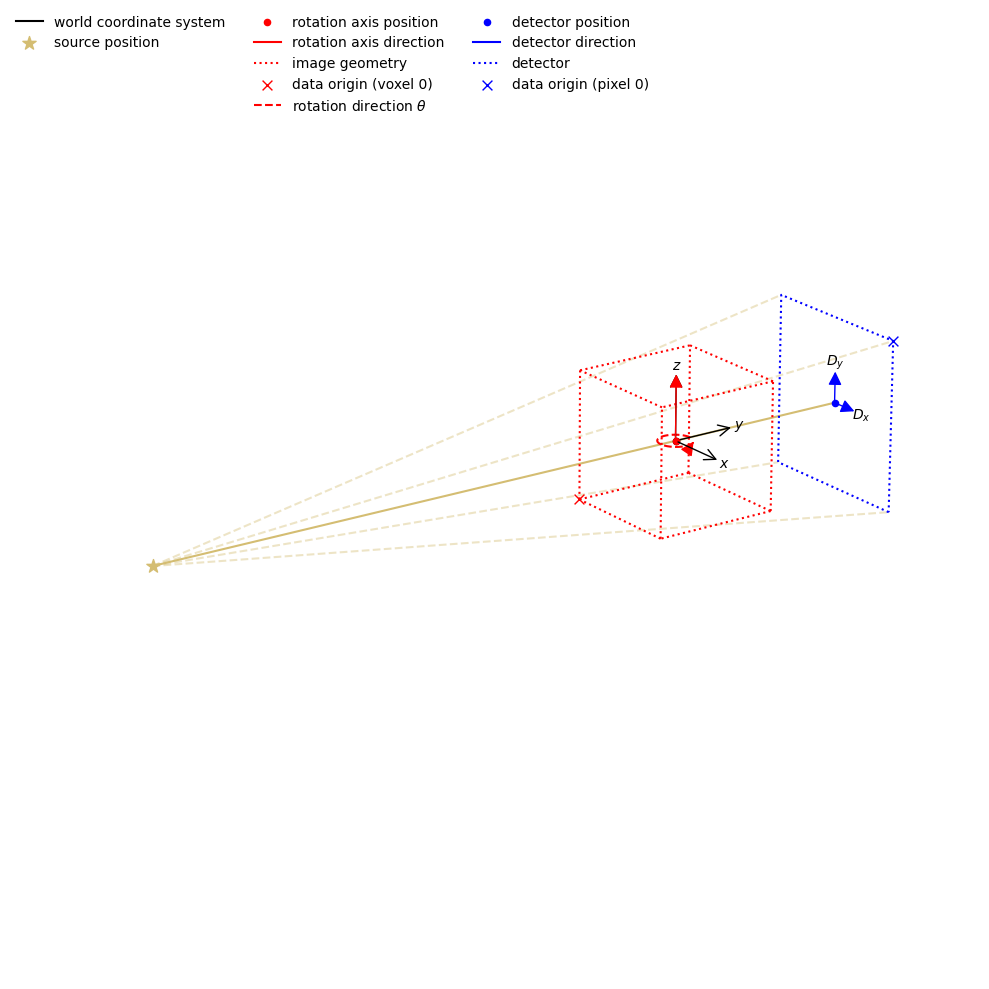

In [6]:
acq_geom = reader.get_geometry()
show_geometry(acq_geom)

In [7]:
print(acq_geom)

3D Cone-beam tomography
System configuration:
	Source position: [    0.  , -1337.05,     0.  ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.   , 442.934,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [ 999 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1560
	Angles 0-9 in degrees: [180.     , 179.76923, 179.53847, 179.3077 , 179.07692, 178.84616,
 178.61539, 178.38461, 178.15384, 177.92308]
	Angles 1550-1559 in degrees: [-177.69226, -177.92303, -178.15381, -178.38458, -178.61533, -178.8461 ,
 -179.07687, -179.30765, -179.53842, -179.7692 ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


## Loading Projections, Cropped Subsets of Interest, and Data Manipulation

To load and display a specific projection of interest we can use the show2D command with the specified projection of interest specified

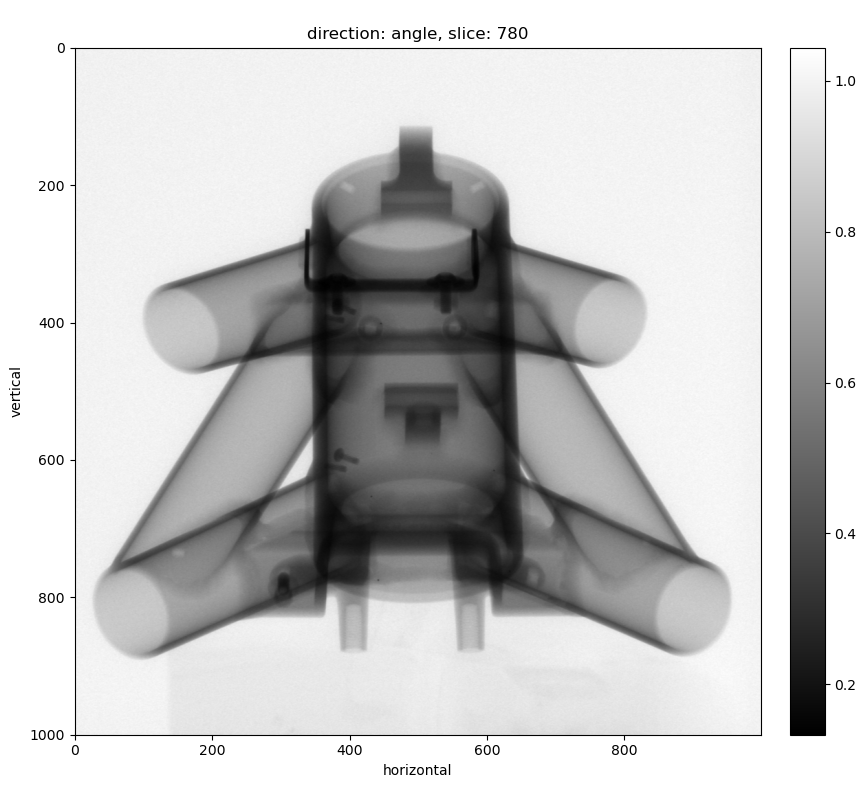

In [8]:
data = reader.read()
show2D(data, origin='upper-left')

By default the NikonDataReader argument `normalise` is `True`, which means all projections are loaded and normalised by the detector white level, which is stored in the .xtekct file as WhiteLevel. If you want to load the data without normalisation, specify `normalise=False`

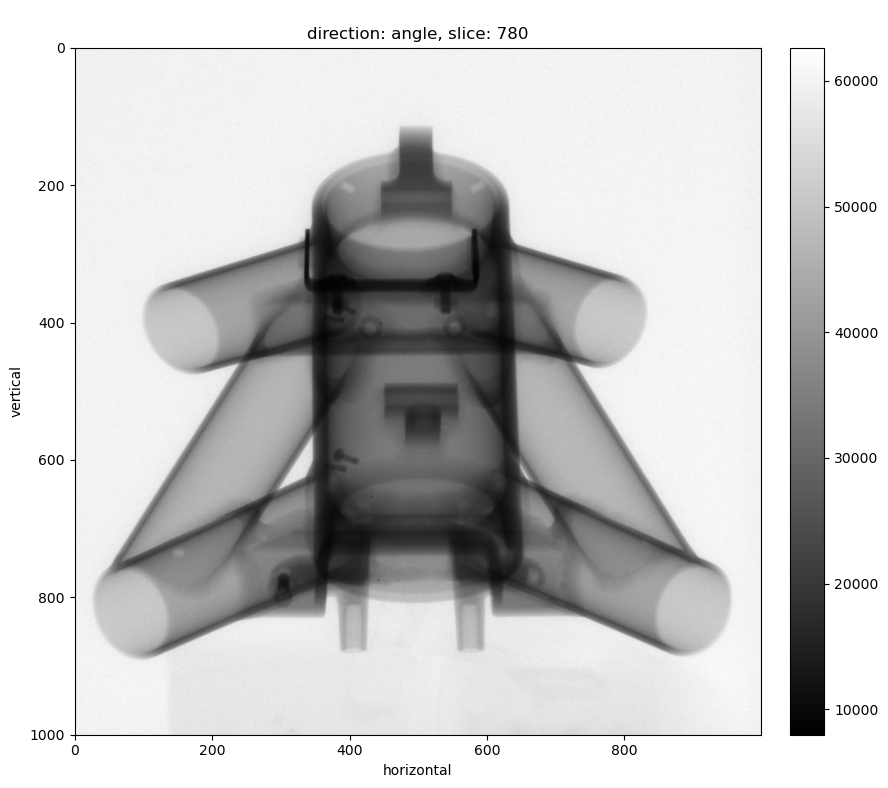

In [7]:
reader = NikonDataReader(file_name=file_path, normalise=False)
data = reader.read()
show2D(data, origin='upper-left')


Use the `roi` argument to load a subset of the data. `roi` should be passed as a dictionary e.g. `{'axis_labels_1': (start, end, step),'axis_labels_2': (start, end, step)}` with axis labels that describe the data dimension labels

To load a cropped subset of the data, change the start and end values. `'axis_label': -1` is a shortcut to load all elements along the axis.



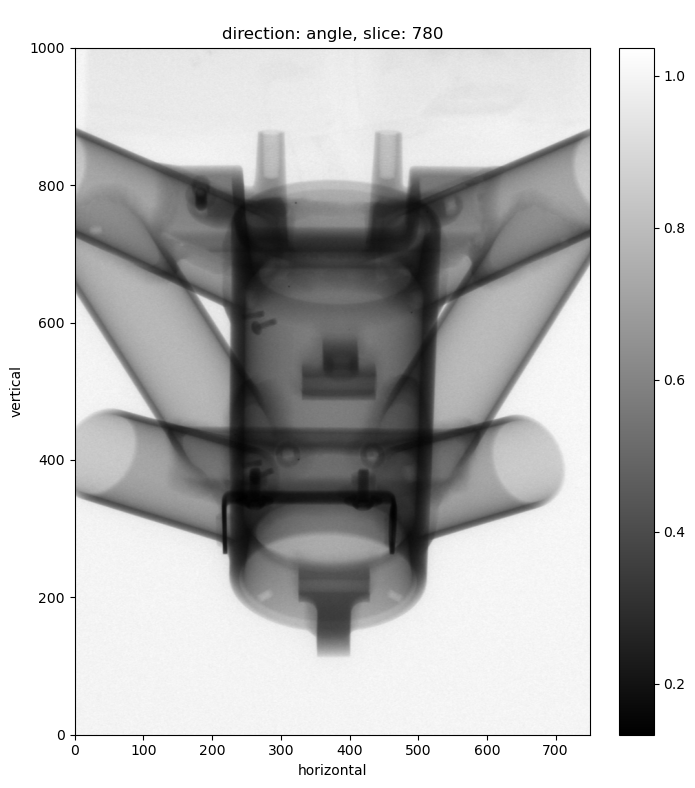

In [8]:
roi = {'horizontal':(120, 870, 1), 'vertical':-1}
reader = NikonDataReader(file_name=file_path, roi=roi)
data = reader.read()
show2D(data)


To load a binned subset of the data, change the step value. Here we use different binning for the horizontal and vertical dimensions which results in a different aspect ratio

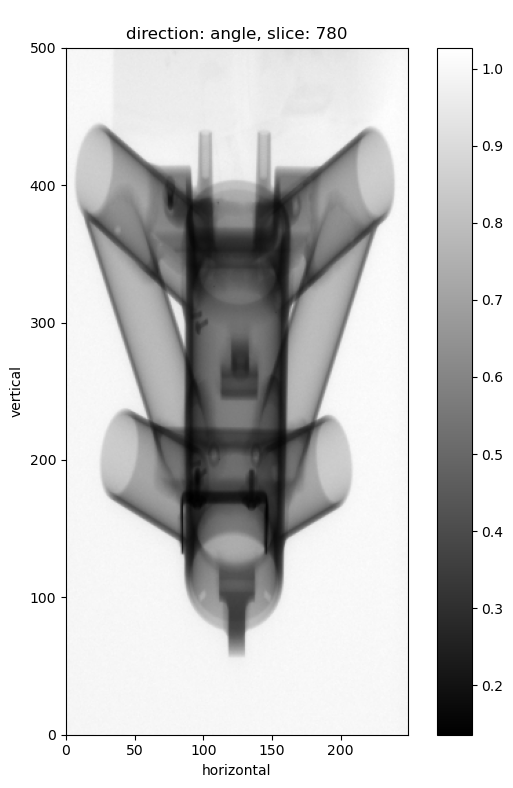

In [9]:
roi = {'horizontal':(None, None, 4), 'vertical':(None, None, 2)}
reader = NikonDataReader(file_name=file_path, roi=roi)
data = reader.read()
show2D(data)

We can also use the argument `fliplr=True` to flip all projections in the vertical axis. If we enable this option we see that the projection is flipped in the left-right direction

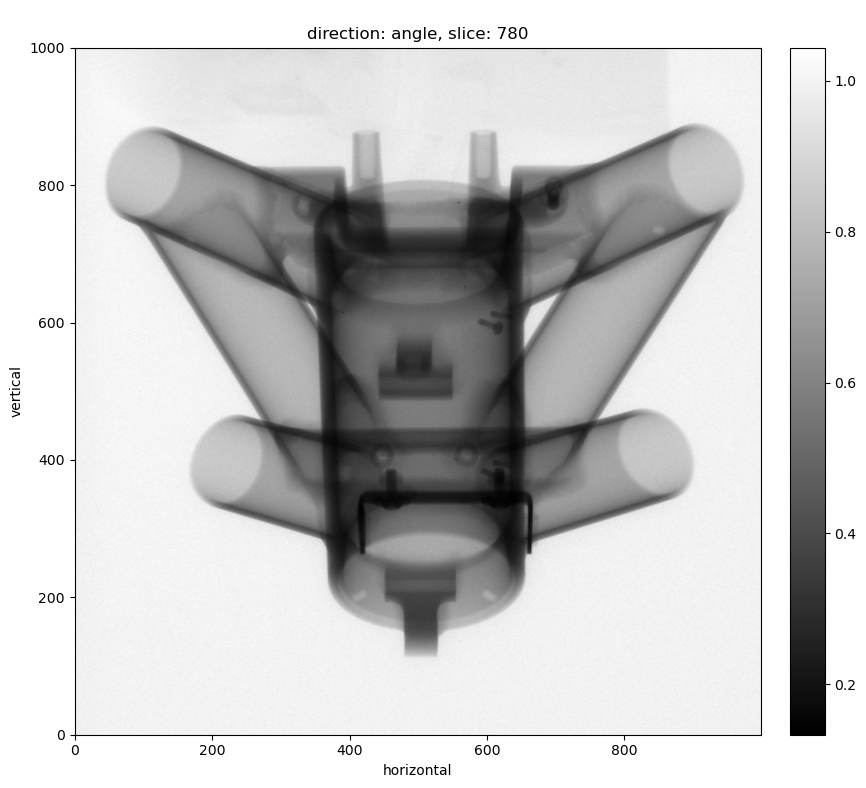

In [9]:
reader = NikonDataReader(file_name=file_path, fliplr=True)
data = reader.read()
show2D(data)

# Pre-processing and Reconstruction

For details of the pre-processing steps performed, see our [CIL-Demos example which uses the same dataset](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/1_Introduction/03_preprocessing.ipynb)! However, in the CIL-demo the data had been converted into the CIL Nexus format first.

Here we load the data, perform conversion from transimission to absorption, and define the image and acquisiton geometries from the data loader.

In [5]:
#from cil.recon import FDK
from cil.plugins.tigre import FBP
from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show2D
from cil.io import NikonDataReader
file_path = '/work3/ljolo/Reader_Hackathon/Nikon_1000_data/RUP_060225_XX_WMG_CCPIDATSETS_EZJB_2_1K.xtekct'
#roi = roi = {'horizontal':(120, 880, 1), 'vertical':-1}
roi = {'horizontal':(None, None, 4), 'vertical':(None, None, 4)}
reader = NikonDataReader(file_name=file_path, roi = roi)
data = reader.read()
data_exp = TransmissionAbsorptionConverter()(data)
data_exp.reorder('tigre')
acq_geom = reader.get_geometry()
img_geom = acq_geom.get_ImageGeometry()

In [6]:
fdk = FBP(img_geom, acq_geom)

fdk.set_input(data_exp)
fdk_recon = fdk.get_output()

Then we can perform the FDK reconstruction

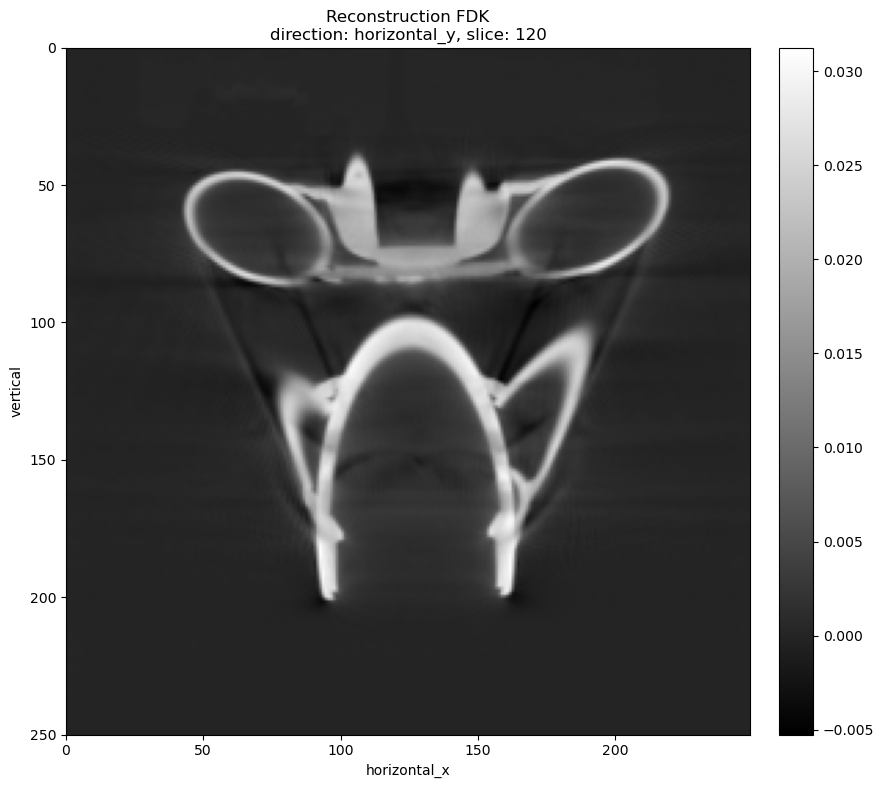

In [7]:
show2D(fdk_recon,slice_list=('horizontal_y', 120), title='Reconstruction FDK',  origin='upper-left')

We can also perform a model based image reconstruction with Total Variaiton regularizaiton and a nonnegativity constraint

In [8]:
from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.tigre.ProjectionOperator import ProjectionOperator

/work3/ljolo/miniconda3/envs/cil/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
A = ProjectionOperator(img_geom, acq_geom, device='gpu')
Grad = GradientOperator(img_geom)
K = BlockOperator(A, Grad)
alpha = 1.0
f1 = 0.5 * L2NormSquared(b=data_exp)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)
g = IndicatorBox(lower=0)


In [17]:
normK = K.norm()
sigma = 1./normK
tau = 1./normK


In [18]:
pdhg = PDHG(f=f, g=g, operator=K, sigma=sigma, tau=tau, update_objective_interval=5)
pdhg.run(40, verbose=2)

100%|████████████████████████████████████████████████████████████████████████| 40/40 [04:09<00:00,  6.23s/it, primal=1.06e+5, dual=4.12e+3, primal_dual=1.02e+5]


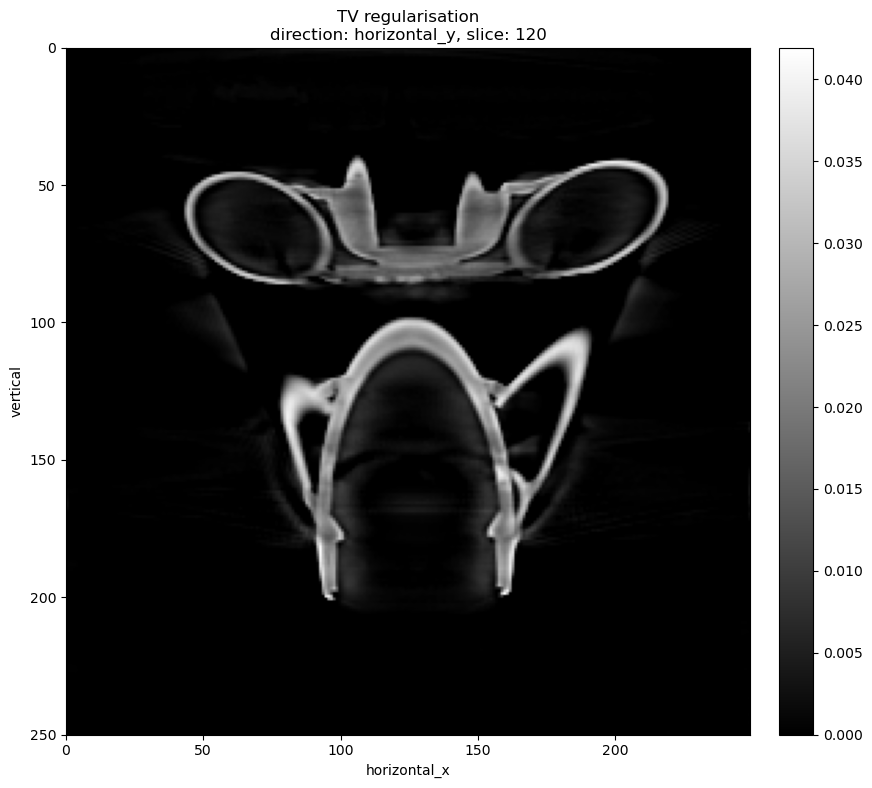

In [19]:
show2D(pdhg.solution,slice_list=('horizontal_y', 120), title='TV regularisation',  origin='upper-left')
#show2D([pdhg.solution, fbp_recon], title=['TV regularisation','FBP'], cmap='inferno', num_cols=2, fix_range=(0,1))